In [9]:
import numpy as np
import pandas as pd
from pathlib import Path
from DTA.plotting import *
from DTA.utils import *
from DTA.Site import Site
from DTA.SymmetricSite import SymmetricSite
from DTA.SiteAcrossReplicas import SiteAcrossReplicas
from DTA.density import *
import sys
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogFormatterExponent
my_cmap = make_custom_colormap()
plt.rcParams['axes.grid'] = False 

## EDIT THESE VARIABLES

In [10]:
root_path = Path("/home/js2746/ELIC5/simulations/PC_CL/5%CDL/")
DPPC_root_path = Path("/home/js2746/ELIC5/simulations/DPPC/")
DPPC_bulk_root_path = Path("/home/js2746/ELIC5/simulations/DPPC_bulk/")
system_names = ["CDL1", "POPC"] # or the names of choice
leaflets = ['upp', 'low'] # analyze both leaflets (default)
replicas = ["rep2", "rep3", "rep4", "rep5"] # replicas as identified in the "root" directory
helix_definitions = root_path.joinpath(replicas[0]) #where are the coordinates for the transmembrane helices?
max_enrichment = 3 # how high do you want your heat map to go?
hmap_height = 3 * len(system_names)
hmap_width = 6

## STEP A: MAKE A HEATMAP OF DENSITY ENRICHMENT

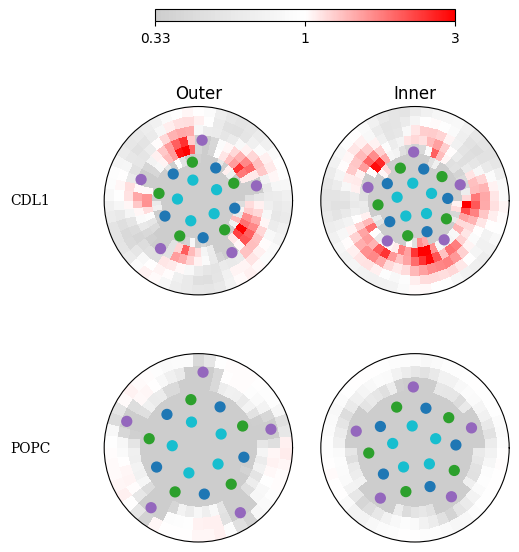

In [11]:
fig1, axes, grid_dims = make_density_enrichment_heatmap(system_names, my_cmap, max_enrichment, helix_definitions, (hmap_height, hmap_width), leaflets, replicas, root_path)
plt.savefig(root_path.joinpath("enrichments.pdf"), bbox_inches='tight')   

## STEP B: MAKE A SYMMETRIC SITE

#### Step B1: Create a Site object.
Give it a name, specify the leaflet (1=outer, 2=inner), and the temperature (in K).

In [12]:
site1 = Site(name="inner M1-M4", leaflet_id=2, temperature=320) # step 1

#### Step B2: Add a list of bin coordinates

In [13]:
site1.bin_coords = [(5, 8), (5, 9), (6, 9), (6, 8), (6, 10)] # step 2

#### Step B3: Make a SymmetricSite object.
- Specify the symmetry. We chose five-fold because we simulated a pentamer.
- Give it your Site object as the base_site.
- Tell it how many theta bins are in your lattice.

In [14]:
symm_site1 = SymmetricSite(symmetry=5, base_site=site1, Ntheta=grid_dims.Ntheta) #step 3

#### Step B4: Outline the site on the heatmap with outline_site()
Each heatmap subplot has a different index. Make sure to choose the correct index. \
For example, if you wanted to measure the binding affinity of POPC in the inner leaflet, \
switch the axes index to '3'.

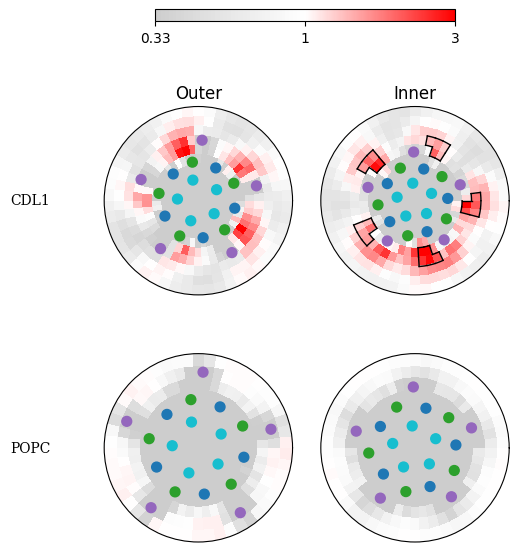

In [15]:
fig1, axes, grid_dims = make_density_enrichment_heatmap(system_names, my_cmap, max_enrichment, helix_definitions, (hmap_height, hmap_width), leaflets, replicas, root_path)

axes[1] = outline_site(axes[1], symm_site1, grid_dims) #step 4

plt.savefig(root_path.joinpath("enrichments_withSites.pdf"), bbox_inches='tight')

#### Step B5 (optional): If you don't like the placement of your site, go back to Step B2 

## Step C: Find accessible area

#### Step C0: Run PolarDensityBin on your 100% DPPC + Protein system
#### Use the same settings that you used for the original system.

#### Step C1: Load the outputs and create a duplicate site, but name it 'DPPC_site1'
We have done this for you.

In [16]:
DPPC_outer = DPPC_root_path.joinpath(f"DPPC.upp.dat")
DPPC_outer_counts, grid_dims, outer_system_info = parse_tcl_dat_file(DPPC_outer, bulk=False)
DPPC_inner = DPPC_root_path.joinpath(f"DPPC.low.dat")
DPPC_inner_counts, grid_dims, inner_system_info = parse_tcl_dat_file(DPPC_inner, bulk=False)

In [18]:
DPPC_site1 = Site(name=site1.name, leaflet_id=site1.leaflet_id, temperature=site1.temperature)
DPPC_site1.bin_coords = site1.bin_coords
DPPC_symm_site1 = SymmetricSite(symmetry=5, base_site=DPPC_site1, Ntheta=grid_dims.Ntheta)

#### Step C2: add the DPPC counts from the correct leaflet
If you made your original site in the outer leaflet, use DPPC_outer_counts!

In [ ]:
DPPC_symm_site1.update_counts_histogram(bulk=False, counts_data=DPPC_inner_counts)

#### Step C3a: Calculate the geometric area of the site

In [23]:
site1_geom_area = round(DPPC_site1.calculate_geometric_area(grid_dims.dr, grid_dims.dtheta))
print(f"Initial guess for accessible area is geometric area: {site1_geom_area} A^2")

Initial guess for accessible area is geometric area: 96 A^2


#### Step C3b: Plot the histogram of DPPC beads in your site

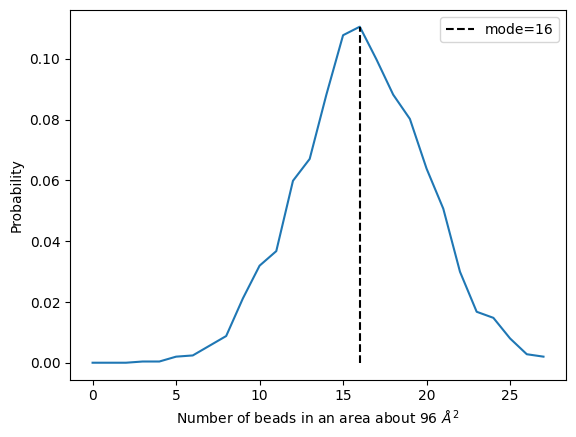

In [25]:
fig,ax = plt.subplots()
ax = plot_histogram(ax, DPPC_symm_site1.site_counts_histogram, site1_geom_area, plot_probability=True)
plt.show()
plt.clf()
plt.close()

#### Step C4a: Edit density_threshold_affinity/accessible_area/do_get_counts.tcl to run on your DPPC bulk system
#### Step C4b: Load your bulk DPPC simulation (no protein) in VMD
#### Step C4c: Run do_get_counts.tcl
#### Step C4d: Load the bulk counts into this notebook
#### Step C4e: Update the bulk counts of DPPC_symm_site1
#### Step C4f: Plot the distribution

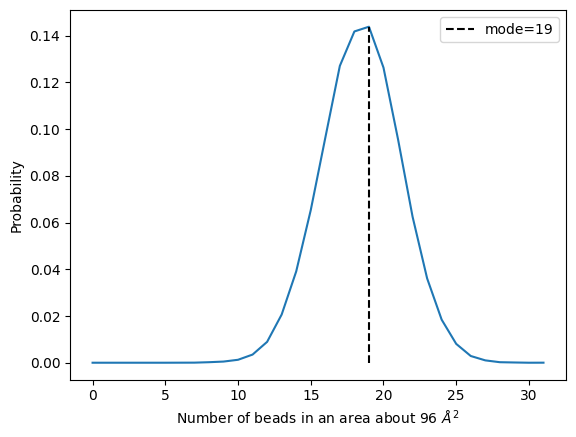

In [ ]:
DPPC_bulk_counts, _, _ = parse_tcl_dat_file(DPPC_bulk_root_path.joinpath(f"DPPC_counts_{site1_geom_area}.out"), bulk=True) #step C4d
DPPC_symm_site1.update_counts_histogram(True, DPPC_bulk_counts) #step C4e
fig,ax = plt.subplots()
ax = plot_histogram(ax, DPPC_symm_site1.bulk_counts_histogram, f"{site1_geom_area}", plot_probability=True) #step C4f
plt.show()
plt.clf()
plt.close()

#### Step C5a: Predict a better guess for the true accessible area of the site

In [27]:
better_guess = round(DPPC_symm_site1.predict_accessible_area(site1_geom_area))
print(f"Rerun do_get_counts.tcl but use this for the area instead: {better_guess} A^2")

Rerun do_get_counts.tcl but use this for the area instead: 81 A^2


#### Step C5b: Rerun do_get_counts.tcl with the better estimate provided above

#### Step C5c: Plot the new distribution: does the mode match step C3b?

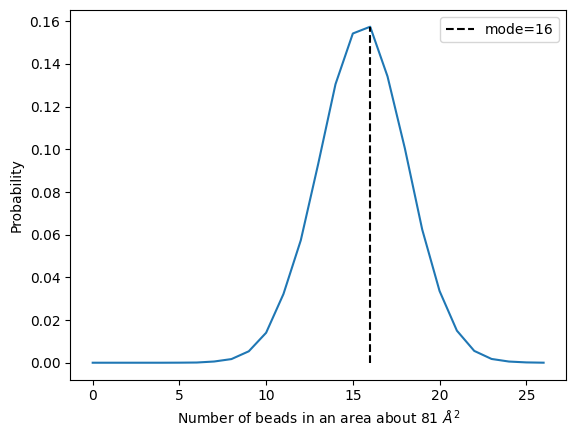

In [29]:
DPPC_bulk_counts, _, _ = parse_tcl_dat_file(DPPC_bulk_root_path.joinpath(f"DPPC_counts_{better_guess}.out"), bulk=True)
DPPC_symm_site1.update_counts_histogram(True, DPPC_bulk_counts)
fig,ax = plt.subplots()
ax = plot_histogram(ax, DPPC_symm_site1.bulk_counts_histogram, f"{better_guess}", plot_probability=True)
plt.show()
plt.clf()
plt.close()

#### Step 5d: If yes, congratulations! You have identified the accessible area of your site. 
#### If no, try running do_get_counts with a smaller area until the modes match.